In [1]:
import pandas as pd
import numpy as np

# Temizlenmiş veri setini oku
df = pd.read_csv("processed_clean_data.csv")

df.shape
df.head()


,Unnamed: 0,ACCOMPLISH_MANDATORY,ACCOMPLISH_MANDATORY_GRADE,ACCOMPLISH_MANDATORY_PCT_GRADED,ACCOMPLISH_MANDATORY_PERCENTILE_GRADE,ACCOMPLISH_OPTIONAL,ACCOMPLISH_OPTIONAL_GRADE,ACCOMPLISH_OPTIONAL_PCT_GRADED,ACCOMPLISH_OPTIONAL_PERCENTILE_GRADE,NP_ACCOMPLISH_MANDATORY_GRADE,...,QUIZ_ATTEMPT_UNIQUE_PCT,QUIZ_CLOSE_ATTEMPT_PCT,QUIZ_CLOSE_ATTEMPT_TIME_1,QUIZ_CLOSE_ATTEMPT_TIME_2,QUIZ_CLOSE_ATTEMPT_TIME_3,QUIZ_CLOSE_ATTEMPT_TIME_PCT,QUIZ_CLOSE_ATTEMPT_UNIQUE_PCT,FORUM_VIEW_FORUM_PCT,FORUM_VIEW_DISCUSSION_PCT,PASS_FAIL
0,0,1.0,9.666667,1.0,43.333333,NaN,NaN,0.0,NaN,9.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
1,1,1.0,9.666667,1.0,43.333333,NaN,NaN,0.0,NaN,9.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
2,2,1.0,9.666667,1.0,43.333333,NaN,NaN,0.0,NaN,9.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
3,3,1.0,9.666667,1.0,43.333333,NaN,NaN,0.0,NaN,9.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.315789,0.0,1
4,4,1.0,9.666667,1.0,43.333333,NaN,NaN,0.0,NaN,9.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1


In [2]:
from sklearn.model_selection import train_test_split

# Hedef değişken
y = df["PASS_FAIL"]

# Feature'lar (TARGET ve PASS_FAIL çıkarılır)
X = df.drop(["PASS_FAIL", "TARGET"], axis=1)

# Stratified split: sınıf oranlarını korur
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(X_train.shape, X_test.shape)


(20208, 67) (5052, 67)


In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

# KNN uzaklık tabanlı olduğu için ölçekleme şart
knn_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # varsa NaN doldur
    ("scaler", StandardScaler()),                   # feature scaling
    ("model", KNeighborsClassifier(n_neighbors=5))  # başlangıç k=5
])

knn_pipe.fit(X_train, y_train)
y_pred_knn = knn_pipe.predict(X_test)

print(" KNN Baseline")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("F1 Score:", f1_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


 KNN Baseline
Accuracy: 0.8855898653998416
F1 Score: 0.9086599241466498
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      1990
           1       0.88      0.94      0.91      3062

    accuracy                           0.89      5052
   macro avg       0.89      0.87      0.88      5052
weighted avg       0.89      0.89      0.88      5052



In [6]:
from sklearn.naive_bayes import GaussianNB

# GaussianNB ölçekleme zorunlu değil ama NaN olmamalı
nb_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", GaussianNB())
])

nb_pipe.fit(X_train, y_train)
y_pred_nb = nb_pipe.predict(X_test)

print("Naive Bayes Baseline")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("F1 Score:", f1_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes Baseline
Accuracy: 0.850356294536817
F1 Score: 0.8772328678142254
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      1990
           1       0.87      0.88      0.88      3062

    accuracy                           0.85      5052
   macro avg       0.84      0.84      0.84      5052
weighted avg       0.85      0.85      0.85      5052



In [8]:
#KNN için Basit Hyperparameter Tuning (k değerleri)
from sklearn.model_selection import GridSearchCV

param_grid = {
    "model__n_neighbors": [3,5,7,9,11,15],
    "model__weights": ["uniform", "distance"]
}

grid_knn = GridSearchCV(
    knn_pipe,
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)

print("En iyi parametreler:", grid_knn.best_params_)
print("En iyi CV F1:", grid_knn.best_score_)

best_knn = grid_knn.best_estimator_
y_pred_best_knn = best_knn.predict(X_test)

print("Tuned KNN")
print("Accuracy:", accuracy_score(y_test, y_pred_best_knn))
print("F1 Score:", f1_score(y_test, y_pred_best_knn))


En iyi parametreler: {'model__n_neighbors': 11, 'model__weights': 'distance'}
En iyi CV F1: 0.9117549374116294
Tuned KNN
Accuracy: 0.8939034045922407
F1 Score: 0.9161976235146967


In [9]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler

# Önce NaN doldur + standartlaştır (ANOVA için iyi)
imputer_fs = SimpleImputer(strategy="median")
X_imputed_train = imputer_fs.fit_transform(X_train)
X_imputed_test  = imputer_fs.transform(X_test)

scaler_fs = StandardScaler()
X_train_fs_scaled = scaler_fs.fit_transform(X_imputed_train)
X_test_fs_scaled  = scaler_fs.transform(X_imputed_test)

# En iyi 20 özelliği seç (k değişebilir)
fs_selector = SelectKBest(score_func=f_classif, k=20)
X_train_anova = fs_selector.fit_transform(X_train_fs_scaled, y_train)
X_test_anova  = fs_selector.transform(X_test_fs_scaled)

selected_cols_anova = X_train.columns[fs_selector.get_support()]
print("ANOVA ile seçilen özellikler:")
print(selected_cols_anova)


ANOVA ile seçilen özellikler:
Index(['ACCOMPLISH_MANDATORY', 'ACCOMPLISH_MANDATORY_GRADE',
       'ACCOMPLISH_MANDATORY_PCT_GRADED',
       'ACCOMPLISH_MANDATORY_PERCENTILE_GRADE',
       'NP_ACCOMPLISH_MANDATORY_GRADE', 'NP_TARGET', 'COURSE_VIEW_PCT',
       'COURSE_VIEW_TIME_1', 'RESOURCE_VIEW_PCT', 'RESOURCE_VIEW_UNIQUE_PCT',
       'ASSIGN_VIEW_PCT', 'ASSIGN_VIEW_UNIQUE_PCT', 'QUIZ_VIEW_UNIQUE_PCT',
       'ASSIGN_SUBMIT_PCT', 'ASSIGN_SUBMIT_TIME_PCT',
       'ASSIGN_SUBMIT_UNIQUE_PCT', 'QUIZ_ATTEMPT_TIME_PCT',
       'QUIZ_ATTEMPT_UNIQUE_PCT', 'QUIZ_CLOSE_ATTEMPT_TIME_PCT',
       'QUIZ_CLOSE_ATTEMPT_UNIQUE_PCT'],
      dtype='object')


In [10]:
# KNN AFTER FS

knn_after_fs = KNeighborsClassifier(n_neighbors=grid_knn.best_params_["model__n_neighbors"],
                                    weights=grid_knn.best_params_["model__weights"])
knn_after_fs.fit(X_train_anova, y_train)
y_pred_knn_fs = knn_after_fs.predict(X_test_anova)

acc_knn_fs = accuracy_score(y_test, y_pred_knn_fs)
f1_knn_fs = f1_score(y_test, y_pred_knn_fs)

print("=== KNN After ANOVA FS ===")
print("Accuracy:", acc_knn_fs)
print("F1 Score:", f1_knn_fs)

# NB AFTER FS

nb_after_fs = GaussianNB()
nb_after_fs.fit(X_train_anova, y_train)
y_pred_nb_fs = nb_after_fs.predict(X_test_anova)

acc_nb_fs = accuracy_score(y_test, y_pred_nb_fs)
f1_nb_fs = f1_score(y_test, y_pred_nb_fs)

print("=== NB After ANOVA FS ===")
print("Accuracy:", acc_nb_fs)
print("F1 Score:", f1_nb_fs)


=== KNN After ANOVA FS ===
Accuracy: 0.9416072842438639
F1 Score: 0.9529130087789306
=== NB After ANOVA FS ===
Accuracy: 0.8935075217735551
F1 Score: 0.9134770022515278


In [11]:
results_hazal = pd.DataFrame([
    ["KNN (Baseline)", accuracy_score(y_test, y_pred_knn), f1_score(y_test, y_pred_knn)],
    ["KNN (Tuned)", accuracy_score(y_test, y_pred_best_knn), f1_score(y_test, y_pred_best_knn)],
    ["KNN (After ANOVA FS)", acc_knn_fs, f1_knn_fs],
    ["Naive Bayes (Baseline)", accuracy_score(y_test, y_pred_nb), f1_score(y_test, y_pred_nb)],
    ["Naive Bayes (After ANOVA FS)", acc_nb_fs, f1_nb_fs]
], columns=["Model", "Accuracy", "F1"])

results_hazal


,Model,Accuracy,F1
0,KNN (Baseline),0.885590,0.908660
1,KNN (Tuned),0.893903,0.916198
2,KNN (After ANOVA FS),0.941607,0.952913
3,Naive Bayes (Baseline),0.850356,0.877233
4,Naive Bayes (After ANOVA FS),0.893508,0.913477


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
# model results
results = {
    "Model": [
        "KNN (Baseline)",
        "KNN (Tuned)",
        "KNN (After ANOVA FS)",
        "Naive Bayes (Baseline)",
        "Naive Bayes (After ANOVA FS)"
    ],
    "Accuracy": [0.8856, 0.8939, 0.9416, 0.8504, 0.8935],
    "F1": [0.9087, 0.9162, 0.9529, 0.8772, 0.9135]
}

df_plot = pd.DataFrame(results)

# Plot style
sns.set(style="whitegrid", font_scale=1.2)


C:\Users\Aras\AppData\Local\Temp\ipykernel_8304\4014334534.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="Model", y="Accuracy", palette="viridis")


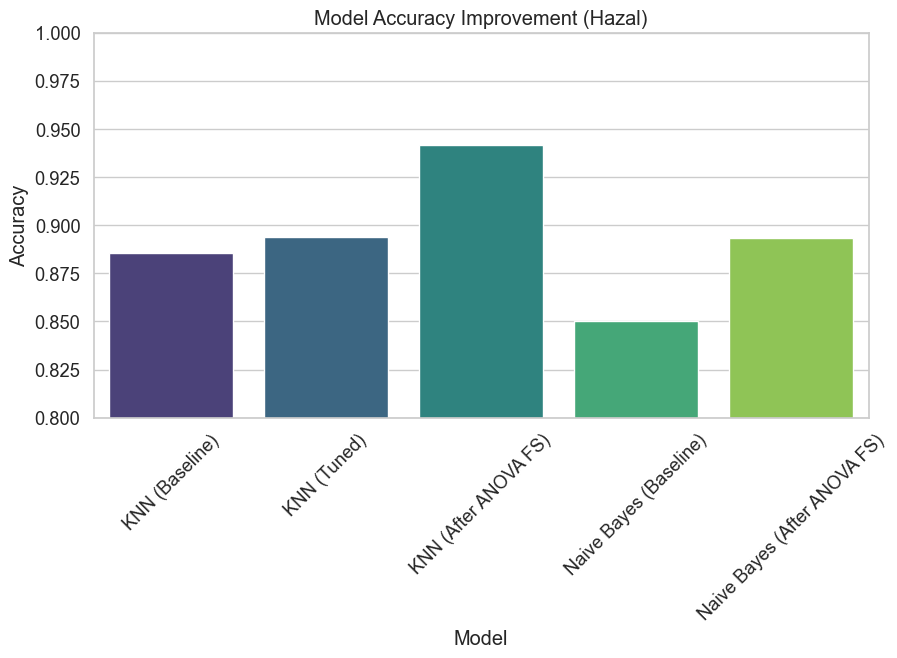

In [ ]:
# Accuracy Plot

plt.figure(figsize=(10,5))
sns.barplot(data=df_plot, x="Model", y="Accuracy", palette="viridis")
plt.title("Model Accuracy Improvement")
plt.xticks(rotation=45)
plt.ylim(0.80, 1.00)
plt.show()

C:\Users\Aras\AppData\Local\Temp\ipykernel_8304\3683705770.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x="Model", y="F1", palette="magma")


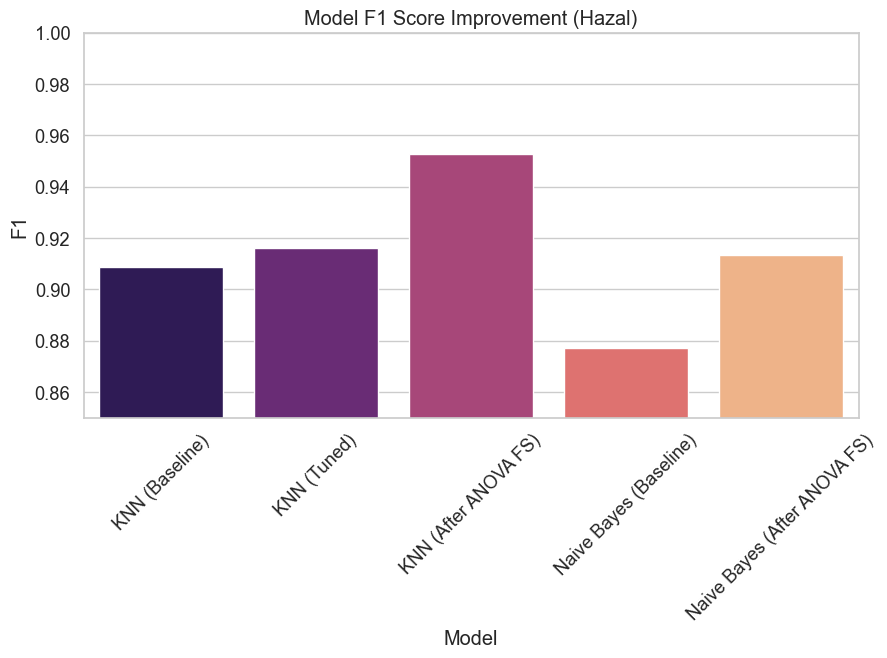

In [ ]:
# F1 Score Plot

plt.figure(figsize=(10,5))
sns.barplot(data=df_plot, x="Model", y="F1", palette="magma")
plt.title("Model F1 Score Improvement")
plt.xticks(rotation=45)
plt.ylim(0.85, 1.00)
plt.show()

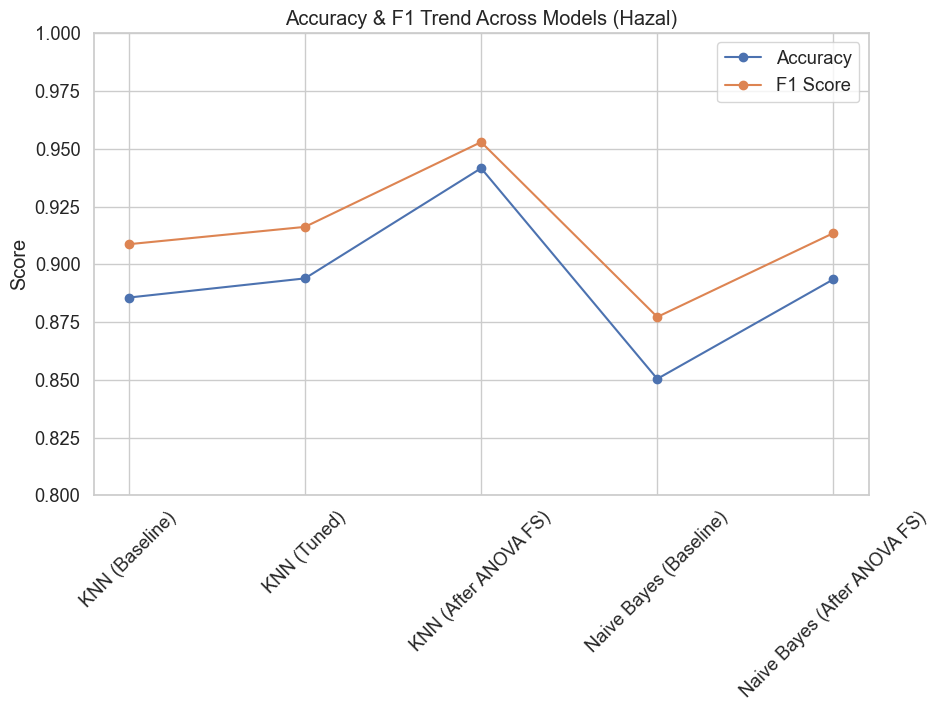

In [ ]:
# Combined Line Plot

plt.figure(figsize=(10,6))
plt.plot(df_plot["Model"], df_plot["Accuracy"], marker="o", label="Accuracy")
plt.plot(df_plot["Model"], df_plot["F1"], marker="o", label="F1 Score")
plt.title("Accuracy & F1 Trend Across Models")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0.80, 1.00)
plt.legend()
plt.grid(True)
plt.show()
